In [1]:
import numpy as np 
import seaborn as sb
import matplotlib.pyplot as plt
import cv2
import os
import re
import random
import pandas as pd
from scipy import ndimage as ndi

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

##### Cell ini berguna untuk mendefinisikan direktori training dan direktori validation

In [2]:
train_dir = "vegDataset/train"
valid_dir = "vegDataset/validation"

In [3]:
# dataset exploration
# load salah satu citra dari masing masing class yang ada, dan menjadikannya sebagai sebuah tensor
explor_data = []
labels = []
testing_path = 'vegDataset/test' 
for label in os.listdir(testing_path): #loop masing masing class
  path = testing_path+'/'+label
  img_paths = os.listdir(path)
  random.shuffle(img_paths)
  img_path = path+'/'+img_paths[0]
  img = plt.imread(img_path) #load image
  img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_LINEAR )
  explor_data.append(img) #masukan citra kedalam list
  labels.append(label) #masukan encoded label kedala list

explor_data = np.array(explor_data)
explor_data.shape

(15, 224, 224, 3)

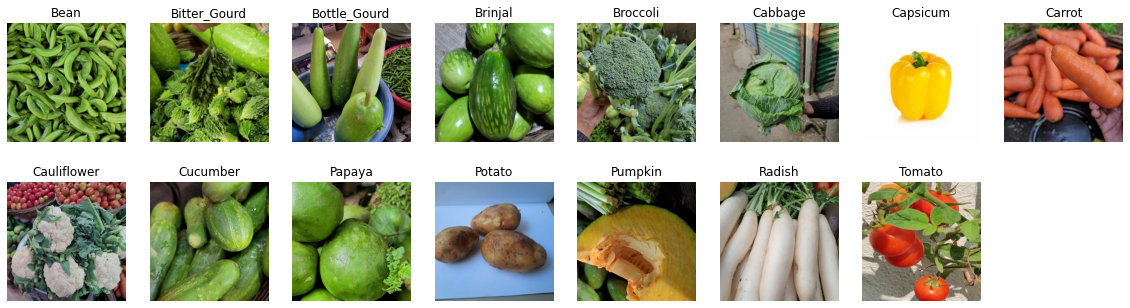

In [4]:
# dataset exploration
plt.figure(figsize=(20,20))
for i in range(15):
  plt.subplot (7,8,i+1)
  plt.title(labels[i])
  plt.axis('off')
  plt.imshow( explor_data[i] )

In [5]:
# cell ini bekerja untuk melakukan augmentasi dataset dimana,

datagen = ImageDataGenerator(
    rescale = 1./255, # dilakukan proses rescaling warna dari 0-255, dinormalisasi ke float 0-1
    rotation_range = 20, # dilakukan rotasi acak sejauh dengan rentang terbesar 20 derajat   
    zoom_range = 0.2, # diperbesar dengan rentang 0.2 kali ukuran asli citra
    shear_range = 0.2, # dipangkas 0.2 ukuran asli citra
    width_shift_range = 0, # tidak memberikan rentang pergeseran lebar
    height_shift_range = 0, # tidak memberikan rentang pergeseran tinggi
    vertical_flip = False,  # tidak melakukan pembalikan vertikal
    fill_mode = 'nearest' # memberikan fill_mode dengan mode 'nearest'
                  )

In [6]:
# cell ini melakukan liad dataset secara bertahap menggunakan datagenerator

train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224), # target ukuran citra untuk dijadikan bentuk tensor
        batch_size=32,
        class_mode='categorical') # mode categorical karena dataset terdiri dari kelas yang berbeda

validation_generator = datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle = False)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [7]:
# menyimpan indeks kelas yang akan digunakan sebagai map untuk testing
train_generator.class_indices

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

In [8]:
# membuat callback untuk mengefisienkan proses training
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback

modelFolder = 'result/' # folder tujuan model akan disimpan

# checkpoint ini digunakan untuk menyimpan model training ketika loss mencapai titik minimum
checkpointLoss = ModelCheckpoint(f"{modelFolder}bestLoss.hdf5", 
                            monitor='loss', 
                            verbose=1,
                            save_best_only=True, 
                            mode='auto')

# checkpoint ini digunakan untuk menyimpan model training ketika loss untuk validation mencapai titik minimum
checkpointValLoss = ModelCheckpoint(f"{modelFolder}bestValLoss.hdf5", 
                            monitor='val_loss', 
                            verbose=1,
                            save_best_only=True, 
                            mode='auto')

# early stop ini membuat model berhenti melakukan proses training ketika tidak ada perubahan setelah beberapa epoch
# di sini terdapat nilai patience sebesar 10 yang berarti apabila tidak ada perubahan nilai loss ataupun val_loss sebanyak 10 epoch berturut-turut,
# maka proses training akan dihentikan saat itu juga.
earlyStopVal = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
earlyStop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

# callback ini hanya berjalan apabila nilai akurasi lebih besar dari 95% dan loss lebih kecil dari 0.1% 
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('loss')<0.001):
            print("\nAkurasi telah mencapai > 95%! dan loss < 0.001")
            self.model.stop_training = True

callbacks = myCallback()

In [9]:
# cell ini membuat model sequential

model = models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(15, activation='sigmoid')
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [10]:
# cell ini meng-compile model yang sudah dibuat dan memberikan loss function serta optimizer yang dibutuhkan
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [11]:
# cell ini melakukan training model dengan data train dan validation
# memberikan jumlah maksimum epoch yang dilakukan dan memberikan callback function
history = model.fit(
                train_generator,
                validation_data=validation_generator,
                epochs=60,
                callbacks=[callbacks,
                           checkpointValLoss, 
                           earlyStopVal
                           ],)

Epoch 1/60
282/469 [=================>............] - ETA: 2:05 - loss: 1.9329 - accuracy: 0.3332

KeyboardInterrupt: 

In [ ]:
# menyimpan model terakhir sesuai dengan pemberhentian callback yang terjadi
model.save(f'{modelFolder}lastModel')

INFO:tensorflow:Assets written to: result/lastModel\assets


INFO:tensorflow:Assets written to: result/lastModel\assets


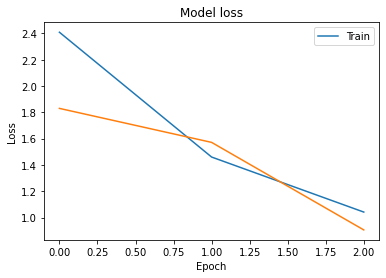

In [ ]:
# plotting untuk menampilkan grafik perubahan loss pada proses training
# grafik yang bergerak turun menandakan kondisi yang baik
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

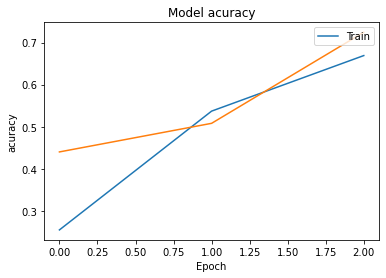

In [ ]:
# plotting untuk menampilkan grafik perubahan akurasi pada proses training
# grafik yang bergerak naik menandakan kondisi yang baik
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acuracy')
plt.ylabel('acuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
# menyimpan riwayat training sebagai perbandingan
import pandas as pd
df = pd.DataFrame()
df["accuracy"] = history.history["accuracy"]
df["val_accuracy"] = history.history['val_accuracy']
df["loss"] = history.history['loss']
df["val_loss"] = history.history["val_loss"]
df.to_csv(f"{modelFolder}history.csv")

In [ ]:
# memuat history untuk analisa
historyBasic = pd.read_csv('result/history.csv')

In [ ]:
# melihat berapa nomor epoch terakhir
print(historyBasic.shape)

(3, 5)


In [ ]:
historyBasic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    3 non-null      int64  
 1   accuracy      3 non-null      float64
 2   val_accuracy  3 non-null      float64
 3   loss          3 non-null      float64
 4   val_loss      3 non-null      float64
dtypes: float64(4), int64(1)
memory usage: 248.0 bytes


In [ ]:
basicEpochs = [i for i in range(3)]

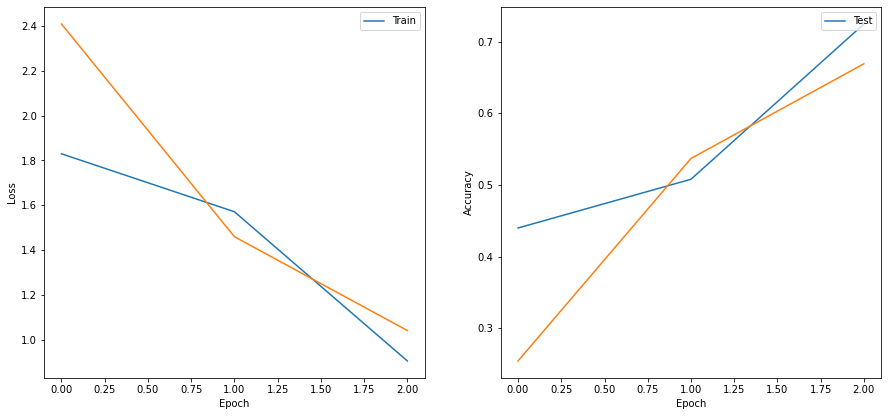

In [ ]:
# plotting untuk menampilkan grafik perubahan loss dan akurasi pada proses training
# grafik loss yang bergerak turun menandakan kondisi yang baik
# grafik akurasi yang bergerak naik menandakan kondisi yang baik
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(historyBasic['val_loss'])
plt.plot(historyBasic['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper right')

plt.subplot(2,2,2)
plt.plot(historyBasic['val_accuracy'])
plt.plot(historyBasic['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Test'], loc='upper right')

In [ ]:
# membuat label map untuk digunakan dalam proses testing
# didapatkan dari proses generate image class pada saat training
labels_map = {'FreshApple': 0,
 'FreshBanana': 1,
 'FreshBellpepper': 2,
 'FreshCarrot': 3,
 'FreshCucumber': 4,
 'FreshMango': 5,
 'FreshOrange': 6,
 'FreshPotato': 7,
 'FreshStrawberry': 8,
 'FreshTomato': 9,
 'RottenApple': 10,
 'RottenBanana': 11,
 'RottenBellpepper': 12,
 'RottenCarrot': 13,
 'RottenCucumber': 14,
 'RottenMango': 15,
 'RottenOrange': 16,
 'RottenPotato': 17,
 'RottenStrawberry': 18,
 'RottenTomato': 19}

In [ ]:
# cell ini memuat semua dataset untuk kemudian diubah menjadi tensor
testing_data = []
labels = []
testing_path = "datasets_splited/test"
for label in os.listdir(testing_path):
  path = testing_path+'/'+label
  for filename in os.listdir(path):
    img_path = path+'/'+filename
    img = plt.imread(img_path)
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_LINEAR )
    testing_data.append(img)
    labels.append(labels_map[label])

testing_data = np.array(testing_data)/255

C:\Users\ACER NITRO\AppData\Local\Temp\ipykernel_17044\192713999.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  testing_data = np.array(testing_data)/255


ValueError: could not broadcast input array from shape (224,224,3) into shape (224,224)

In [ ]:
# cell ini memuat model yang sudah dibuat sebelumnya
basicModel = models.load_model('result/bestValLoss.hdf5')

In [ ]:
# menampilkan laporan model dan akurasi data mencapai 90%
print(classification_report(labels, testBasic))

NameError: name 'testBasic' is not defined